In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [4]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility,ACANet_GAT, ACANet_GCN, ACANet_GIN
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [5]:
ACANET_MODEL = ACANet_GCN

In [6]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets

@torch.no_grad()
def test(test_loader, model, aca_loss):
    model.eval()
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    for i, data in enumerate(test_loader):
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



def Test_performance(alpha=1.0):
    
    model = ACANET_MODEL(**pub_args, aggr = 'mean').to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, squared=True, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)

        _, _, _, _, train_n_pos_triplets, train_rmse = test(train_loader, model, aca_loss)
        _, _, _, _, val_n_pos_triplets, val_rmse = test(val_loader, model, aca_loss)
        _, _, _, _, test_n_pos_triplets, test_rmse = test(test_loader, model, aca_loss)

        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 
                        'n_pos_triplets':n_pos_triplets, 
                        'train_n_pos_triplets':train_n_pos_triplets,
                        'val_n_pos_triplets':val_n_pos_triplets,
                        'test_n_pos_triplets':test_n_pos_triplets,
                       
                       })
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

In [7]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            # 'aggregators': ['mean', 'min', 'max', 'sum','std'],
            # 'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [8]:
len(Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42))

1125

In [9]:
# train, valid, test splitting
res1 = []
res2 = []
for seed in [8, 16, 24, 42, 64, 128, 256, 512, 1024, 2048]:
    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    deg = get_deg(train_dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # With AC-Awareness ($\alpha = 1$)
    df1 = Test_performance(alpha=1.0)
    df1['seed'] = seed
    # Without AC-Awareness ($\alpha = 0$)
    df2 = Test_performance(alpha=0.0)
    df2['seed'] = seed
    res1.append(df1)
    res2.append(df2)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 397.7817 tsm_loss: 352.8533 reg_loss: 44.9284 n_pos_triplets: 194985;  Val: 6.0871 Test: 6.1197
Epoch: 002, Loss: 298.1382 tsm_loss: 261.6228 reg_loss: 36.5154 n_pos_triplets: 193275;  Val: 5.7936 Test: 5.8192
Epoch: 003, Loss: 242.1835 tsm_loss: 214.9327 reg_loss: 27.2508 n_pos_triplets: 190553;  Val: 5.1601 Test: 5.1892
Epoch: 004, Loss: 185.2837 tsm_loss: 167.9028 reg_loss: 17.3809 n_pos_triplets: 187487;  Val: 4.1669 Test: 4.1974
Epoch: 005, Loss: 143.4581 tsm_loss: 134.7551 reg_loss: 8.7030 n_pos_triplets: 186202;  Val: 2.8432 Test: 2.8728
Epoch: 006, Loss: 124.4609 tsm_loss: 121.5452 reg_loss: 2.9157 n_pos_triplets: 186303;  Val: 1.4759 Test: 1.4721
Epoch: 007, Loss: 105.4786 tsm_loss: 103.8661 reg_loss: 1.6125 n_pos_triplets: 181557;  Val: 1.1811 Test: 1.1048
Epoch: 008, Loss: 93.5098 tsm_loss: 91.3390 reg_loss: 2.1709 n_pos_triplets: 178838;  Val: 1.1945 Test: 1.1162
Epoch: 009, Loss: 83.0268 tsm_loss: 81.3937 reg_loss: 1.6330 n_pos_triplets: 176128;  Val: 1.0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 43.4450 tsm_loss: 401.0919 reg_loss: 43.4450 n_pos_triplets: 194249;  Val: 6.2270 Test: 6.2491
Epoch: 002, Loss: 35.9029 tsm_loss: 385.9174 reg_loss: 35.9029 n_pos_triplets: 193823;  Val: 5.9798 Test: 5.9999
Epoch: 003, Loss: 27.5634 tsm_loss: 367.8850 reg_loss: 27.5634 n_pos_triplets: 191391;  Val: 5.4514 Test: 5.4689
Epoch: 004, Loss: 18.2954 tsm_loss: 362.3645 reg_loss: 18.2954 n_pos_triplets: 193483;  Val: 4.5345 Test: 4.5449
Epoch: 005, Loss: 8.9736 tsm_loss: 363.7675 reg_loss: 8.9736 n_pos_triplets: 191939;  Val: 3.1737 Test: 3.1673
Epoch: 006, Loss: 2.6617 tsm_loss: 351.0147 reg_loss: 2.6617 n_pos_triplets: 190508;  Val: 1.6086 Test: 1.5546
Epoch: 007, Loss: 1.6904 tsm_loss: 338.5234 reg_loss: 1.6904 n_pos_triplets: 188614;  Val: 1.1147 Test: 1.0120
Epoch: 008, Loss: 2.3636 tsm_loss: 328.0567 reg_loss: 2.3636 n_pos_triplets: 187507;  Val: 1.0826 Test: 0.9916
Epoch: 009, Loss: 1.3897 tsm_loss: 310.7629 reg_loss: 1.3897 n_pos_triplets: 187500;  Val: 1.0864 Test: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 708.6792 tsm_loss: 663.4442 reg_loss: 45.2350 n_pos_triplets: 198086;  Val: 6.4482 Test: 6.2243
Epoch: 002, Loss: 595.4389 tsm_loss: 557.0626 reg_loss: 38.3763 n_pos_triplets: 195393;  Val: 6.1672 Test: 5.9463
Epoch: 003, Loss: 420.1312 tsm_loss: 390.2326 reg_loss: 29.8986 n_pos_triplets: 193647;  Val: 5.6191 Test: 5.4008
Epoch: 004, Loss: 331.0241 tsm_loss: 310.7524 reg_loss: 20.2718 n_pos_triplets: 191167;  Val: 4.7188 Test: 4.5029
Epoch: 005, Loss: 255.0204 tsm_loss: 244.4265 reg_loss: 10.5940 n_pos_triplets: 188764;  Val: 3.4209 Test: 3.2151
Epoch: 006, Loss: 206.8385 tsm_loss: 203.1961 reg_loss: 3.6424 n_pos_triplets: 189306;  Val: 1.9459 Test: 1.7827
Epoch: 007, Loss: 167.1909 tsm_loss: 165.6708 reg_loss: 1.5202 n_pos_triplets: 187382;  Val: 1.1430 Test: 1.1460
Epoch: 008, Loss: 140.4504 tsm_loss: 138.2639 reg_loss: 2.1865 n_pos_triplets: 186830;  Val: 1.0970 Test: 1.1612
Epoch: 009, Loss: 124.4607 tsm_loss: 122.7811 reg_loss: 1.6796 n_pos_triplets: 184802;  Val

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 46.5785 tsm_loss: 534.4250 reg_loss: 46.5785 n_pos_triplets: 198374;  Val: 6.6850 Test: 6.4634
Epoch: 002, Loss: 41.8983 tsm_loss: 496.5091 reg_loss: 41.8983 n_pos_triplets: 197730;  Val: 6.5263 Test: 6.3030
Epoch: 003, Loss: 35.9692 tsm_loss: 520.7907 reg_loss: 35.9692 n_pos_triplets: 196732;  Val: 6.1766 Test: 5.9551
Epoch: 004, Loss: 28.6396 tsm_loss: 484.0845 reg_loss: 28.6396 n_pos_triplets: 198504;  Val: 5.5642 Test: 5.3442
Epoch: 005, Loss: 19.6509 tsm_loss: 455.3330 reg_loss: 19.6509 n_pos_triplets: 194559;  Val: 4.5609 Test: 4.3472
Epoch: 006, Loss: 10.4896 tsm_loss: 416.7970 reg_loss: 10.4896 n_pos_triplets: 194694;  Val: 3.1481 Test: 2.9521
Epoch: 007, Loss: 3.4628 tsm_loss: 399.6427 reg_loss: 3.4628 n_pos_triplets: 194221;  Val: 1.5508 Test: 1.4228
Epoch: 008, Loss: 1.6123 tsm_loss: 326.3691 reg_loss: 1.6123 n_pos_triplets: 188851;  Val: 1.2406 Test: 1.3015
Epoch: 009, Loss: 2.3376 tsm_loss: 295.6863 reg_loss: 2.3376 n_pos_triplets: 189485;  Val: 1.1866 Te

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 190, Loss: 3.0937 tsm_loss: 2.9036 reg_loss: 0.1901 n_pos_triplets: 72586;  Val: 0.6849 Test: 0.6799
Epoch: 191, Loss: 2.6688 tsm_loss: 2.4846 reg_loss: 0.1842 n_pos_triplets: 69698;  Val: 0.6878 Test: 0.6793
Epoch: 192, Loss: 2.7137 tsm_loss: 2.5174 reg_loss: 0.1963 n_pos_triplets: 70654;  Val: 0.6914 Test: 0.6827
Epoch: 193, Loss: 2.8280 tsm_loss: 2.6350 reg_loss: 0.1930 n_pos_triplets: 70654;  Val: 0.6867 Test: 0.6812
Epoch: 194, Loss: 2.7739 tsm_loss: 2.5881 reg_loss: 0.1859 n_pos_triplets: 70151;  Val: 0.6848 Test: 0.6776
Epoch: 195, Loss: 2.7204 tsm_loss: 2.5429 reg_loss: 0.1776 n_pos_triplets: 69936;  Val: 0.6879 Test: 0.6809
Epoch: 196, Loss: 2.6763 tsm_loss: 2.4900 reg_loss: 0.1864 n_pos_triplets: 68853;  Val: 0.6838 Test: 0.6773
Epoch: 197, Loss: 2.6798 tsm_loss: 2.4934 reg_loss: 0.1864 n_pos_triplets: 68706;  Val: 0.6842 Test: 0.6764
Epoch: 198, Loss: 2.7193 tsm_loss: 2.5369 reg_loss: 0.1824 n_pos_triplets: 71769;  Val: 0.6874 Test: 0.6756
Epoch: 199, Loss: 2.7260 tsm

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 43.8003 tsm_loss: 623.5961 reg_loss: 43.8003 n_pos_triplets: 195094;  Val: 6.3969 Test: 6.5364
Epoch: 002, Loss: 38.6817 tsm_loss: 547.5657 reg_loss: 38.6817 n_pos_triplets: 194730;  Val: 6.2266 Test: 6.3629
Epoch: 003, Loss: 33.1963 tsm_loss: 587.5500 reg_loss: 33.1963 n_pos_triplets: 195810;  Val: 5.9389 Test: 6.0733
Epoch: 004, Loss: 26.5842 tsm_loss: 576.9272 reg_loss: 26.5842 n_pos_triplets: 195308;  Val: 5.4654 Test: 5.5940
Epoch: 005, Loss: 18.9130 tsm_loss: 512.8084 reg_loss: 18.9130 n_pos_triplets: 192800;  Val: 4.7618 Test: 4.8795
Epoch: 006, Loss: 11.0798 tsm_loss: 557.9530 reg_loss: 11.0798 n_pos_triplets: 193657;  Val: 3.7725 Test: 3.8714
Epoch: 007, Loss: 4.6433 tsm_loss: 541.6866 reg_loss: 4.6433 n_pos_triplets: 192336;  Val: 2.5071 Test: 2.5728
Epoch: 008, Loss: 1.7937 tsm_loss: 543.7675 reg_loss: 1.7937 n_pos_triplets: 191606;  Val: 1.4612 Test: 1.4886
Epoch: 009, Loss: 1.9616 tsm_loss: 465.0171 reg_loss: 1.9616 n_pos_triplets: 189696;  Val: 1.1817 Te

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 349.1925 tsm_loss: 305.1564 reg_loss: 44.0360 n_pos_triplets: 193048;  Val: 6.4045 Test: 6.4236
Epoch: 002, Loss: 268.1796 tsm_loss: 229.4118 reg_loss: 38.7677 n_pos_triplets: 191723;  Val: 6.2115 Test: 6.2234
Epoch: 003, Loss: 213.2530 tsm_loss: 181.0572 reg_loss: 32.1958 n_pos_triplets: 187490;  Val: 5.7964 Test: 5.8035
Epoch: 004, Loss: 172.7583 tsm_loss: 147.8005 reg_loss: 24.9579 n_pos_triplets: 184589;  Val: 5.1894 Test: 5.1891
Epoch: 005, Loss: 143.0485 tsm_loss: 125.6150 reg_loss: 17.4335 n_pos_triplets: 182095;  Val: 4.3455 Test: 4.3351
Epoch: 006, Loss: 112.0361 tsm_loss: 101.8139 reg_loss: 10.2222 n_pos_triplets: 182836;  Val: 3.2793 Test: 3.2585
Epoch: 007, Loss: 91.2739 tsm_loss: 86.7865 reg_loss: 4.4875 n_pos_triplets: 179903;  Val: 2.1135 Test: 2.0942
Epoch: 008, Loss: 80.4179 tsm_loss: 78.7949 reg_loss: 1.6230 n_pos_triplets: 176632;  Val: 1.2528 Test: 1.2801
Epoch: 009, Loss: 72.4696 tsm_loss: 71.1315 reg_loss: 1.3382 n_pos_triplets: 170519;  Val: 1.1

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 43.6262 tsm_loss: 446.4007 reg_loss: 43.6262 n_pos_triplets: 194651;  Val: 6.2964 Test: 6.3112
Epoch: 002, Loss: 37.3674 tsm_loss: 454.7961 reg_loss: 37.3674 n_pos_triplets: 193837;  Val: 6.0994 Test: 6.1095
Epoch: 003, Loss: 29.8541 tsm_loss: 422.0914 reg_loss: 29.8541 n_pos_triplets: 191479;  Val: 5.6018 Test: 5.6084
Epoch: 004, Loss: 20.6959 tsm_loss: 383.2942 reg_loss: 20.6959 n_pos_triplets: 192443;  Val: 4.7100 Test: 4.7118
Epoch: 005, Loss: 10.7417 tsm_loss: 359.4501 reg_loss: 10.7417 n_pos_triplets: 187113;  Val: 3.2754 Test: 3.2822
Epoch: 006, Loss: 3.2693 tsm_loss: 328.7259 reg_loss: 3.2693 n_pos_triplets: 187500;  Val: 1.5640 Test: 1.5907
Epoch: 007, Loss: 1.6978 tsm_loss: 293.0488 reg_loss: 1.6978 n_pos_triplets: 188768;  Val: 1.2247 Test: 1.2358
Epoch: 008, Loss: 2.4129 tsm_loss: 281.1002 reg_loss: 2.4129 n_pos_triplets: 184460;  Val: 1.2029 Test: 1.2098
Epoch: 009, Loss: 1.4307 tsm_loss: 268.2481 reg_loss: 1.4307 n_pos_triplets: 183665;  Val: 1.0984 Test

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 430.4079 tsm_loss: 383.4818 reg_loss: 46.9260 n_pos_triplets: 190908;  Val: 6.4739 Test: 6.5672
Epoch: 002, Loss: 338.4877 tsm_loss: 296.9476 reg_loss: 41.5400 n_pos_triplets: 188371;  Val: 6.2729 Test: 6.3671
Epoch: 003, Loss: 263.4992 tsm_loss: 228.8418 reg_loss: 34.6574 n_pos_triplets: 188416;  Val: 5.8951 Test: 5.9911
Epoch: 004, Loss: 214.4559 tsm_loss: 187.1876 reg_loss: 27.2682 n_pos_triplets: 186002;  Val: 5.2953 Test: 5.3909
Epoch: 005, Loss: 163.8765 tsm_loss: 144.6913 reg_loss: 19.1852 n_pos_triplets: 184317;  Val: 4.3977 Test: 4.4936
Epoch: 006, Loss: 149.1647 tsm_loss: 138.0908 reg_loss: 11.0739 n_pos_triplets: 182968;  Val: 3.2016 Test: 3.2958
Epoch: 007, Loss: 118.2443 tsm_loss: 113.4765 reg_loss: 4.7678 n_pos_triplets: 179117;  Val: 1.9418 Test: 2.0154
Epoch: 008, Loss: 101.7699 tsm_loss: 100.1531 reg_loss: 1.6168 n_pos_triplets: 176072;  Val: 1.2169 Test: 1.2036
Epoch: 009, Loss: 92.3797 tsm_loss: 90.8340 reg_loss: 1.5457 n_pos_triplets: 174461;  Val:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
df1 = pd.concat(res1)
df2 = pd.concat(res2)

In [11]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

In [12]:
df1 = pd.read_csv('./with_aca.csv', index_col = 0)
df2 = pd.read_csv('./without_aca.csv', index_col = 0)

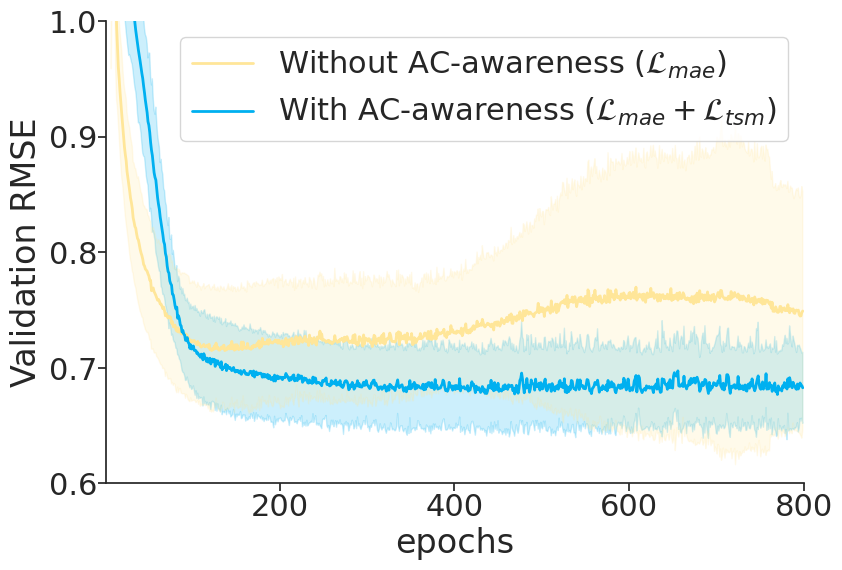

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'val_rmse'

n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Validation_RMSE.pdf', bbox_inches='tight', dpi=400) 

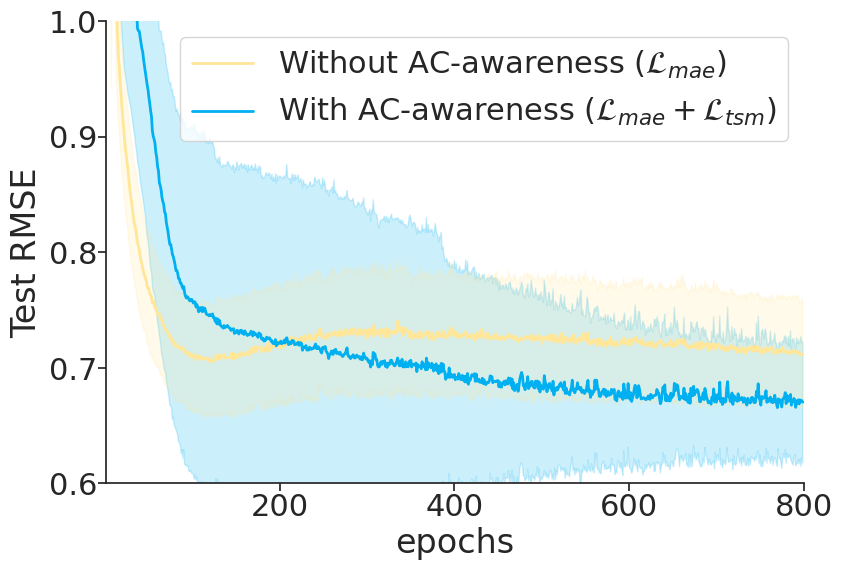

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'test_rmse'



dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Test_RMSE.pdf' , bbox_inches='tight', dpi=400) 

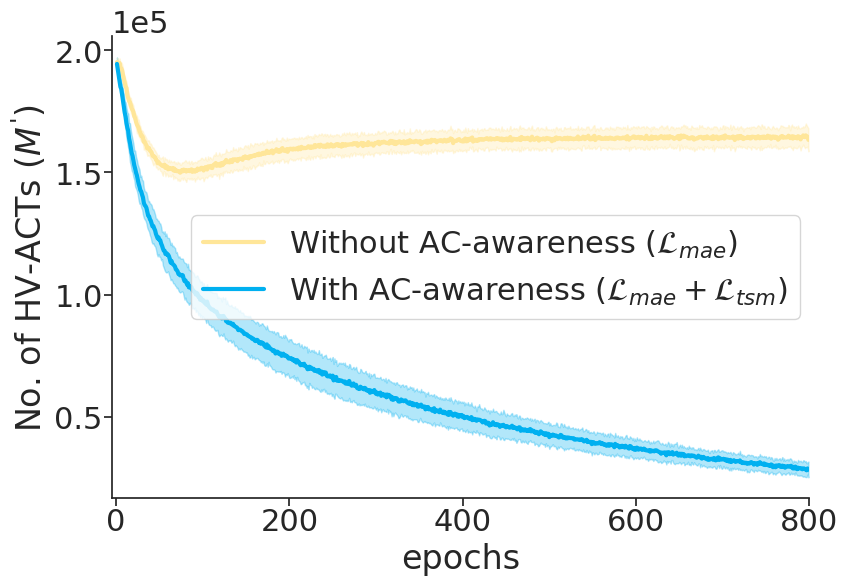

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))


y = 'n_pos_triplets'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.spines[['right', 'top']].set_visible(False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel("No. of HV-ACTs ($M^'$)")
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
ax.set_xlim(-5,800)


fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Number_of_mined_ACTs_during_training.pdf' , bbox_inches='tight', dpi=400) 

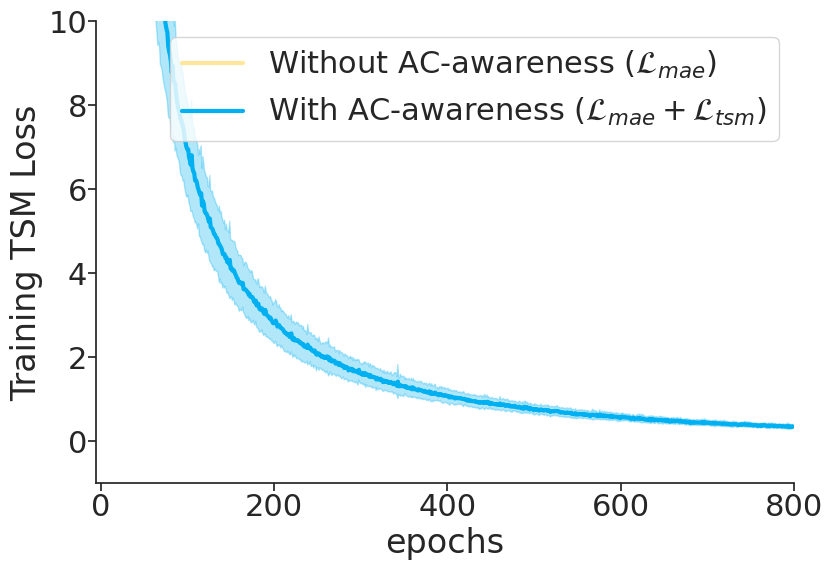

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))
y = 'train_triplet_loss'
dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-5,800)
ax.set_ylim(-1,10)

ax.set_ylabel('Training TSM Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Triplet_loss_during_training.pdf', bbox_inches='tight', dpi=400) 

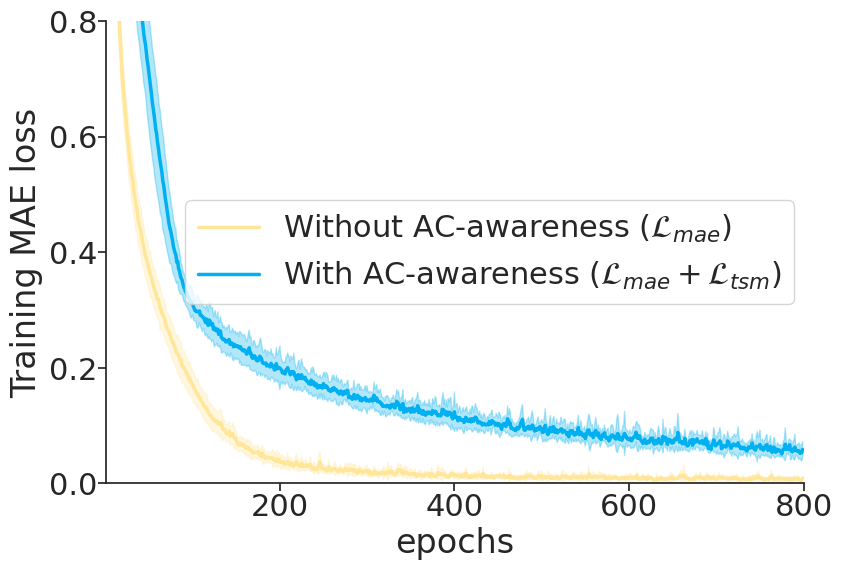

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))

y = 'train_mae_loss'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2.5, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)



ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)


ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')
ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Train_mae_los.pdf', bbox_inches='tight', dpi=400) 